In [48]:
import polars as pl
# g_patent.tsv
df_patent = pl.read_csv(
    "g_patent.tsv",
    separator="\t",
    columns=["patent_id", "patent_date"],
    schema_overrides={"patent_id": pl.Utf8, "patent_date": pl.Utf8},
    ignore_errors=True
).with_columns([
    pl.col("patent_date").str.strptime(pl.Date, "%Y-%m-%d", strict=False)
])

# g_cpc_current.tsv
df_cpc = pl.read_csv(
    "g_cpc_current.tsv",
    separator="\t",
    columns=["patent_id", "cpc_class"],
    schema_overrides={"patent_id": pl.Utf8, "cpc_class": pl.Utf8}
)

# g_assignee_disambiguated.tsv
df_assignee = pl.read_csv(
    "g_assignee_disambiguated.tsv",
    separator="\t",
    columns=["patent_id", "location_id"],
    schema_overrides={"patent_id": pl.Utf8, "location_id": pl.Utf8}
)

# g_location_disambiguated.tsv
df_location = pl.read_csv(
    "g_location_disambiguated.tsv",
    separator="\t",
    columns=["location_id", "disambig_country"],
    schema_overrides={"location_id": pl.Utf8, "disambig_country": pl.Utf8}
)
# g_cpc_title.tsv
df_cpc_title = pl.read_csv(
    "g_cpc_title.tsv",
    separator="\t",
    columns=["cpc_class", "cpc_class_title"],
    schema_overrides={"cpc_class": pl.Utf8, "cpc_class_title": pl.Utf8}
)




In [49]:

df_pa = df_cpc.join(df_assignee, on="patent_id", how="inner")


In [50]:
df_pal = df_pa.join(df_location, on="location_id", how="inner")

In [51]:
df_full = df_pal.join(df_patent, on="patent_id", how="inner")

In [55]:
df_full_unique = df_full.unique(subset=["patent_id"])

In [59]:
print(df_full.height)
print(df_full_unique.height)

54918973
7340285


In [63]:
# -------------------------------
# CÁLCULO DE RCA
# -------------------------------

df_full_unique = df_full_unique.with_columns([
    pl.col("patent_date").dt.year().alias("year")
])

# Conteo de patentes por país, clase, y año
df_counts = df_full_unique.group_by(["disambig_country", "cpc_class", "year"]).agg(
    pl.len().alias("patents_country_class_year")
)

# Totales
df_total_country_year = df_counts.group_by(["disambig_country", "year"]).agg(
    pl.sum("patents_country_class_year").alias("total_country_year")
)

df_total_class_year = df_counts.group_by(["cpc_class", "year"]).agg(
    pl.sum("patents_country_class_year").alias("total_class_year")
)

df_total_year = df_counts.group_by("year").agg(
    pl.sum("patents_country_class_year").alias("total_global_year")
)

# RCA = (x_cr / x_r) / (x_c / x_total)
df_rca = (
    df_counts
    .join(df_total_country_year, on=["disambig_country", "year"], how="left")
    .join(df_total_class_year, on=["cpc_class", "year"], how="left")
    .join(df_total_year, on="year", how="left")
    .with_columns([
        pl.col("patents_country_class_year"),
        pl.col("total_country_year"),
        pl.col("total_class_year"),
        pl.col("total_global_year")
    ])
    .with_columns([
        (
            (pl.col("patents_country_class_year") / pl.col("total_country_year")) /
            (pl.col("total_class_year") / pl.col("total_global_year"))
        ).alias("rca")
    ])
)

# -------------------------------
# 4. Resultado
# -------------------------------

print(df_rca.head())


shape: (5, 8)
┌─────────────┬───────────┬──────┬─────────────┬─────────────┬─────────────┬────────────┬──────────┐
│ disambig_co ┆ cpc_class ┆ year ┆ patents_cou ┆ total_count ┆ total_class ┆ total_glob ┆ rca      │
│ untry       ┆ ---       ┆ ---  ┆ ntry_class_ ┆ ry_year     ┆ _year       ┆ al_year    ┆ ---      │
│ ---         ┆ str       ┆ i32  ┆ year        ┆ ---         ┆ ---         ┆ ---        ┆ f64      │
│ str         ┆           ┆      ┆ ---         ┆ u32         ┆ u32         ┆ u32        ┆          │
│             ┆           ┆      ┆ u32         ┆             ┆             ┆            ┆          │
╞═════════════╪═══════════╪══════╪═════════════╪═════════════╪═════════════╪════════════╪══════════╡
│ CH          ┆ C04       ┆ 1992 ┆ 9           ┆ 1071        ┆ 685         ┆ 80910      ┆ 0.992578 │
│ LU          ┆ F01       ┆ 2012 ┆ 3           ┆ 236         ┆ 1962        ┆ 235845     ┆ 1.528048 │
│ SA          ┆ B81       ┆ 2003 ┆ 2           ┆ 19          ┆ 186         ┆ 

In [64]:
df_rca.select([
    pl.col(col).is_null().sum().alias(f"{col}_nulls")
    for col in df_rca.columns
])


disambig_country_nulls,cpc_class_nulls,year_nulls,patents_country_class_year_nulls,total_country_year_nulls,total_class_year_nulls,total_global_year_nulls,rca_nulls
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


In [65]:
df_rca_binaria = df_rca.with_columns([
    (pl.col("rca") > 1).cast(pl.Int8).alias("rca_binary")
])

In [66]:
print(df_rca_binaria.head(10))

shape: (10, 9)
┌────────────┬───────────┬──────┬────────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ disambig_c ┆ cpc_class ┆ year ┆ patents_co ┆ … ┆ total_clas ┆ total_glob ┆ rca       ┆ rca_binar │
│ ountry     ┆ ---       ┆ ---  ┆ untry_clas ┆   ┆ s_year     ┆ al_year    ┆ ---       ┆ y         │
│ ---        ┆ str       ┆ i32  ┆ s_year     ┆   ┆ ---        ┆ ---        ┆ f64       ┆ ---       │
│ str        ┆           ┆      ┆ ---        ┆   ┆ u32        ┆ u32        ┆           ┆ i8        │
│            ┆           ┆      ┆ u32        ┆   ┆            ┆            ┆           ┆           │
╞════════════╪═══════════╪══════╪════════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ CH         ┆ C04       ┆ 1992 ┆ 9          ┆ … ┆ 685        ┆ 80910      ┆ 0.992578  ┆ 0         │
│ LU         ┆ F01       ┆ 2012 ┆ 3          ┆ … ┆ 1962       ┆ 235845     ┆ 1.528048  ┆ 1         │
│ SA         ┆ B81       ┆ 2003 ┆ 2          ┆ … ┆ 186        ┆ 150286     ┆

In [70]:
green_classes = [
    "A01", "A23", "A43", "A47", "A61", "B01", "B03", "B09", "B22", "B29", "B30",
    "B62", "B63", "B65", "C02", "C03", "C04", "C05", "C08", "C09", "C10", "C12",
    "C21", "C22", "D01", "D21", "E01", "E02", "E03", "F01", "F02", "F16", "F17",
    "F23", "F27", "G01", "G08", "H01", "Y02"
]

In [71]:
df_rca_binaria_green = df_rca_binaria.filter(
    pl.col("cpc_class").is_in(green_classes)
)


In [ ]:
import polars as pl
import pandas as pd
import plotly.express as px
import pycountry

# transform ISO-2 to ISO-3
def iso2_to_iso3(iso2):
    try:
        return pycountry.countries.get(alpha_2=iso2).alpha_3
    except:
        return None


df_pd = df_rca_binaria_green.to_pandas()

# only rca_binary == 1
df_map = (
    df_pd[df_pd["rca_binary"] == 1]
    .groupby("disambig_country")
    .size()
    .reset_index(name="green_rca_count")
)

df_map["iso_alpha_3"] = df_map["disambig_country"].apply(iso2_to_iso3)

fig = px.choropleth(
    df_map,
    locations="iso_alpha_3",
    color="green_rca_count",
    color_continuous_scale="Greens",
    title="Green Technologies with RCA > 1 by Country"
)
fig.update_layout(
    title_font=dict(size=20, family="Arial", color="darkgreen"),
    geo=dict(showframe=False, showcoastlines=True, coastlinecolor="gray"),
    margin=dict(l=0, r=0, t=50, b=0)
)
fig.update_geos(projection_type="robinson")
fig.update_geos(showcoastlines=True, coastlinecolor="Black")
fig.update_geos(showland=True, landcolor="LightGray")
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.show()


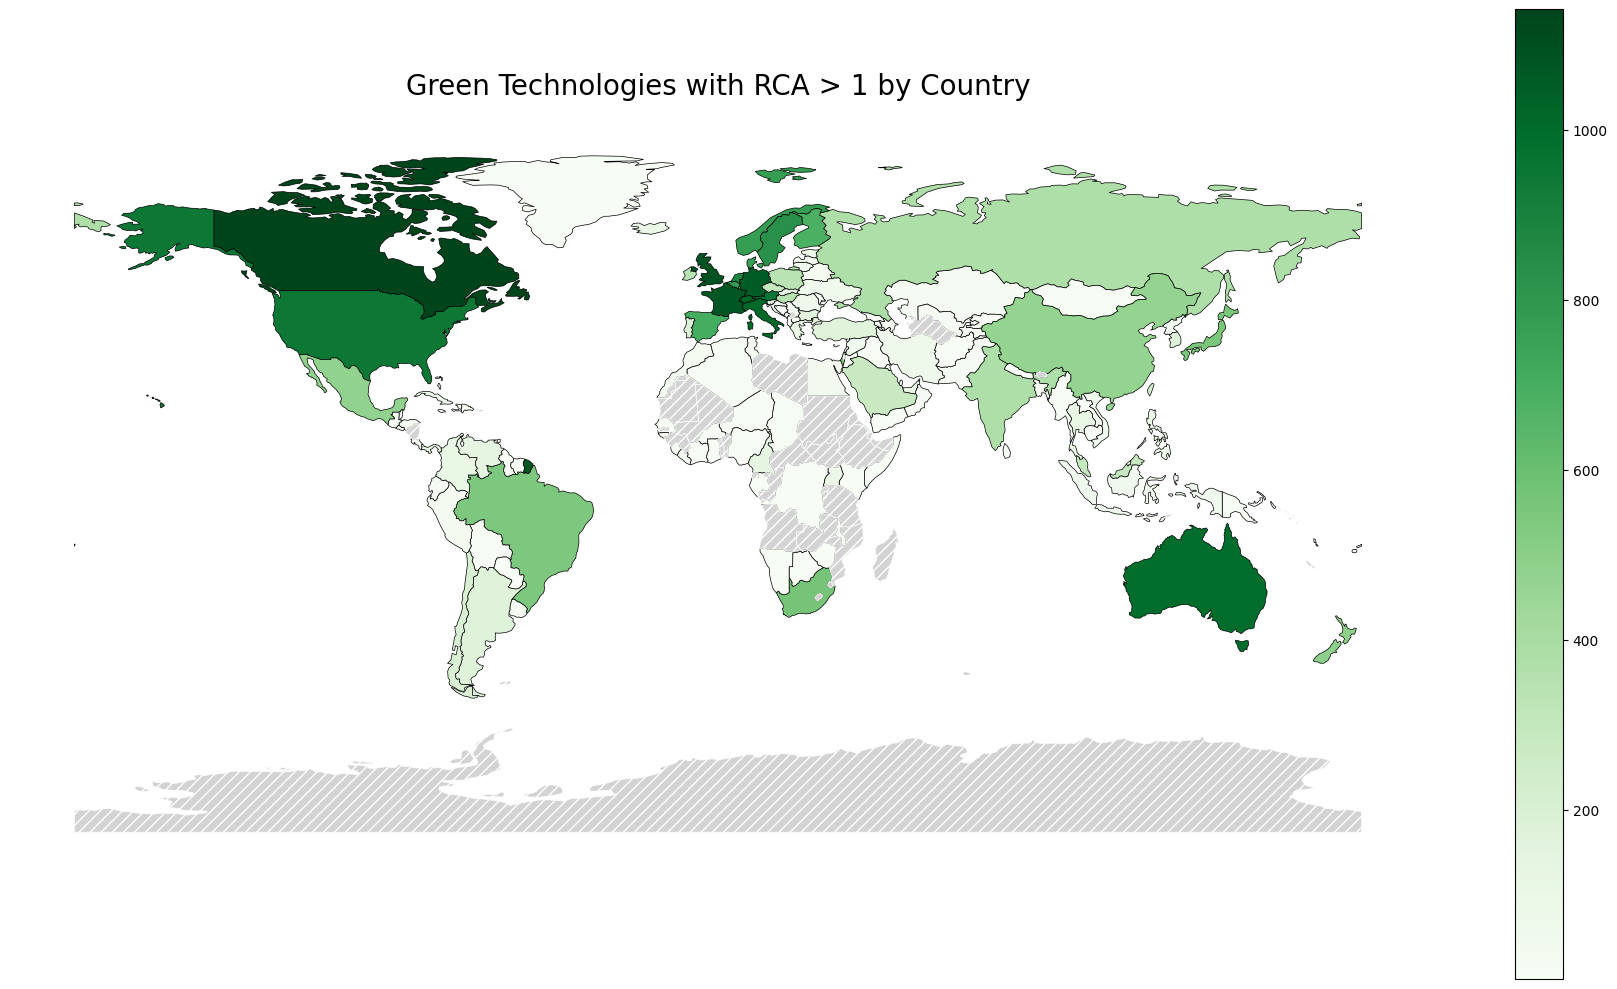

In [87]:
import geopandas as gpd

df_filtered = df_pd[df_pd["rca_binary"] == 1].copy()

df_filtered["iso_alpha_3"] = df_filtered["disambig_country"].apply(iso2_to_iso3)

df_map = df_filtered.groupby("iso_alpha_3").size().reset_index(name="green_rca_count")

world = gpd.read_file("ne_110m_admin_0_countries.shp")

world = world.merge(df_map, left_on="ADM0_A3", right_on="iso_alpha_3", how="left")

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
world.plot(
    column="green_rca_count",
    cmap="Greens",
    linewidth=0.5,
    edgecolor="black",
    ax=ax,
    legend=True,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "white",
        "hatch": "///",
        "label": "No data"
    }
)

ax.set_title("Green Technologies with RCA > 1 by Country", fontsize=20, pad=20)
ax.axis("off")
plt.tight_layout()
plt.show()
